# What Journals Have Been Citing My Organization? 

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty citing publications from authors affiliation to a selected research organization. 

We start from a [GRID](https://grid.ac/) identifier (representing a research organization in Dimensions) and then select all publications citing research where at least one author is/as affiliated to that GRID ID. We then group this publications by source (journal) and sort them by frequency.  


## 1. Load libraries and log in

In [17]:
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly_express -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import os
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm import tqdm_notebook as tqdm

#
# charts libs
import plotly_express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

DimCli v0.6.1.2 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


A couple of utilities to simplify exporting the results we find as CSV files:

In [18]:
#
# data-saving utils
#
DATAFOLDER = "extraction1"
#
if not os.path.exists(DATAFOLDER):
  !mkdir $DATAFOLDER
  print(f"==\nCreated data folder:", DATAFOLDER + "/")
#
def save_as_csv(df, save_name_without_extension):
    "usage: `save_as_csv(dataframe, 'filename')`"
    df.to_csv(f"{DATAFOLDER}/{save_name_without_extension}.csv", index=False)
    print("===\nSaved: ", f"{DATAFOLDER}/{save_name_without_extension}.csv")

## 2. Choose a Research Organization

For the purpose of this exercise, we will are going to use [grid.471244.0](https://grid.ac/institutes/grid.471244.0). Feel free though to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).


In [19]:
GRIDID = "grid.414299.3" #@param {type:"string"}

    
#@markdown The start/end year of publications used to extract patents
YEAR_START = 2000 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2016 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

#
# gen link to Dimensions
#
def dimensions_url(grids):
    root = "https://app.dimensions.ai/discover/publication?or_facet_research_org="
    return root + "&or_facet_research_org=".join([x for x in grids])

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Preview {} Dimensions &#x29c9;</a>'.format(dimensions_url([GRIDID]), GRIDID)))

## 3. Building a Publications Baseset

First we extract all publications where at least one of the authors is affiliated to GRID_ORG. 

This will then let us query for citing publications using the `reference_ids` field (see the [Dimensions API data model](https://docs.dimensions.ai/dsl/data-model.html) for more details). 

In [20]:
publications = dsl.query_iterative(f"""
search publications 
    where research_orgs.id = "{GRIDID}"
    and year in [{YEAR_START}:{YEAR_END}]
    return publications[id+title+doi+year]
""")

#
# save the data
pubs_cited = publications.as_dataframe()
save_as_csv(pubs_cited, f"pubs_{GRIDID}")

1000 / 2540
2000 / 2540
2540 / 2540
===
Saved:  extraction1/pubs_grid.414299.3.csv


## 4. Extracting Publications Citing the Baseset

In the next step we extract all publications citing the publications previously extracted. This query will return JSON data which can be further analyzed e.g. to count the unique number of journals they were published in.

E.g.:

```
'publications': [
  {'journal': {'id': 'jour.1295784',
    'title': 'IEEE Transactions on Cognitive and Developmental Systems'},
   'publisher': 'Institute of Electrical and Electronics Engineers (IEEE)',
   'year': 2018,
   'id': 'pub.1061542201',
   'issn': ['2379-8920', '2379-8939']},
  {'journal': {'id': 'jour.1043581', 'title': 'International Geology Review'},
   'publisher': 'Taylor & Francis',
   'year': 2018,
   'id': 'pub.1087302818',
   'issn': ['0020-6814', '1938-2839']}, etc..
```

This is query template we use. 

In [21]:
query_template = """search publications 
                    where journal is not empty 
                    and reference_ids in {}
                    return publications[id+journal+issn+year+publisher]"""

Note the `{}` part which is where we will put lists of publication IDs (from the previous extraction) during each iteration. This is to ensure our query is never too long (<400 IDs is a good way to ensure we never get an API error).

In [22]:
from tqdm import tqdm_notebook as pbar

pubids = list(pubs_cited['id'])

#
# loop through all source-publications IDs in chunks and query Dimensions 

print("===\nExtracting publications data ...")
results = []
BATCHSIZE = 200
VERBOSE = False # set to True to see extraction logs

for chunk in pbar(list(chunks_of(pubids, BATCHSIZE))):
    query = query_template.format(json.dumps(chunk))
    data = dsl.query_iterative(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)
    

#
# put the citing pub data into a dataframe, remove duplicates and save

pubs_citing = pd.DataFrame().from_dict(results)
print("===\nCiting Publications found: ", len(pubs_citing))
pubs_citing.drop_duplicates(subset='id', inplace=True)
print("Unique Citing Publications found: ", len(pubs_citing))

#
# split up nested journal columns into two columns
journals = pubs_citing['journal'].apply(pd.Series).rename(columns={"id": "journal.id", "title": "journal.title"})
pubs_citing = pd.concat([pubs_citing.drop(['journal'], axis=1), journals], axis=1)

#
# save
save_as_csv(pubs_citing, f"pubs_citing_{GRIDID}")

#
# preview the data
print("===\nPreview:")
pubs_citing.head(10)

===
Extracting publications data ...



===
Citing Publications found:  49685
Unique Citing Publications found:  44512
===
Saved:  extraction1/pubs_citing_grid.414299.3.csv
===
Preview:


issn  year       publisher  \
0                      [0169-2607, 1872-7565]  2020        Elsevier   
1                      [0753-3322, 1950-6007]  2020        Elsevier   
2                      [0003-6870, 1872-9126]  2020        Elsevier   
3                      [0169-2607, 1872-7565]  2020        Elsevier   
4                      [0379-0738, 1872-6283]  2020        Elsevier   
5                      [1054-8807, 1879-1336]  2020        Elsevier   
6  [2411-1457, 2415-346X, 24111457, 2415346X]  2019  Ukrinformnauka   
7                      [0009-7322, 1524-4539]  2019  Wolters Kluwer   
8                      [0009-7322, 1524-4539]  2019  Wolters Kluwer   
9                      [0009-7322, 1524-4539]  2019  Wolters Kluwer   

               id    journal.id  \
0  pub.1122297560  jour.1013238   
1  pub.1122514358  jour.1371653   
2  pub.1120500934  jour.1014244   
3  pub.1121427232  jour.1013238   
4  pub.1122308206  jour.1015489   
5  pub.1121652132  jour.1102747   
6  pub.1117378584  jour.1150567   
7  pub.1121231338  jour.1009570   
8  pub.1121231339  jour.1009570   
9  pub.1121231336  jour.1009570   

                                       journal.title  
0       Computer Methods and Programs in Biomedicine  
1                      Biomedicine & Pharmacotherapy  
2                                 Applied Ergonomics  
3       Computer Methods and Programs in Biomedicine  
4                     Forensic Science International  
5                           Cardiovascular Pathology  
6  Shidnoevropejskij zurnal vnutrisnoi ta simejno...  
7                                        Circulation  
8                                        Circulation  
9                                        Circulation

## 5. Journal Analysis
Finally, we can analyze the citing publications by grouping them by source journal. This can be achieved easily thanks to pandas' Dataframe methods.  

> [pandas](https://pandas.pydata.org/pandas-docs/stable/) is a popular Python software library for data manipulation and analysis

#### Number of Unique journals

In [23]:
pubs_citing['journal.id'].describe()

count            44512
unique            6169
top       jour.1037553
freq               602
Name: journal.id, dtype: object

#### Most frequent journals

In [24]:
# 
# count journals and rename columns
journals = pubs_citing['journal.title'].value_counts()
journals = journals.to_frame().reset_index().rename(columns= {"index": 'journal.title', 'journal.title': 'count'})
journals.index.name = 'index'

#
# save
save_as_csv(journals, f"top_journals_citing_{GRIDID}")

#preview
journals.head(100)

===
Saved:  extraction1/top_journals_citing_grid.414299.3.csv


journal.title  count
index                                                          
0                                               PLoS ONE    602
1                      World Journal of Gastroenterology    294
2                            Inflammatory Bowel Diseases    292
3                    International Journal of Cardiology    196
4                                     Scientific Reports    172
...                                                  ...    ...
95                  Cancer Chemotherapy and Pharmacology     58
96     Annual International Conference of the IEEE En...     58
97                                      BMJ Case Reports     57
98                          Techniques in Coloproctology     57
99                                                 Drugs     57

[100 rows x 2 columns]

#### Top 100 journals chart

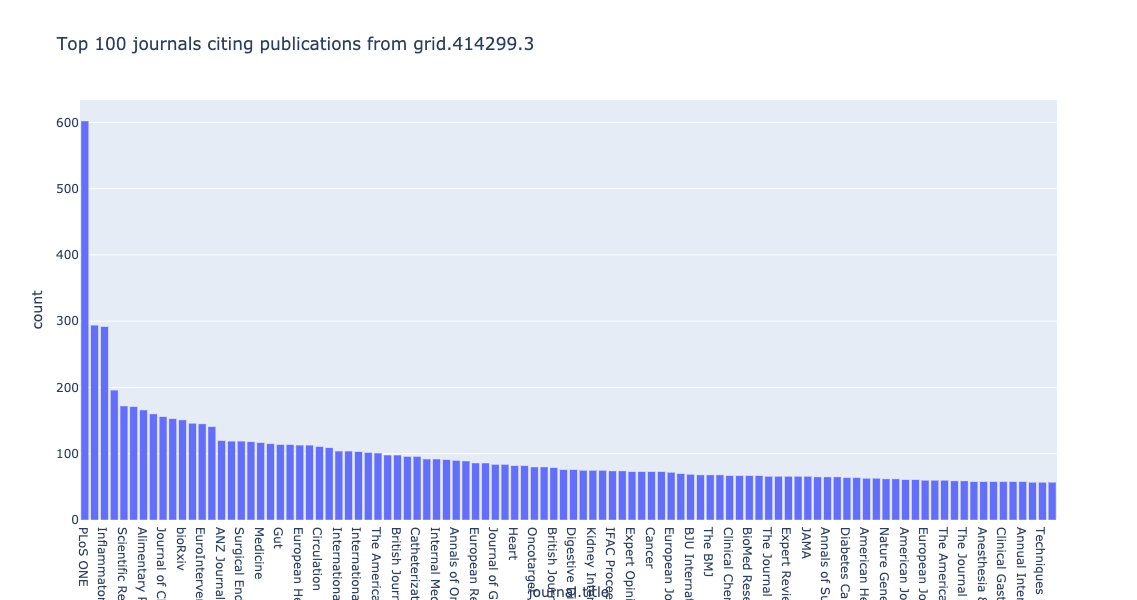

In [25]:
px.bar(journals[:100], x="journal.title", y="count", 
       title=f"Top 100 journals citing publications from {GRIDID}")

#### Top 20 journals by year chart

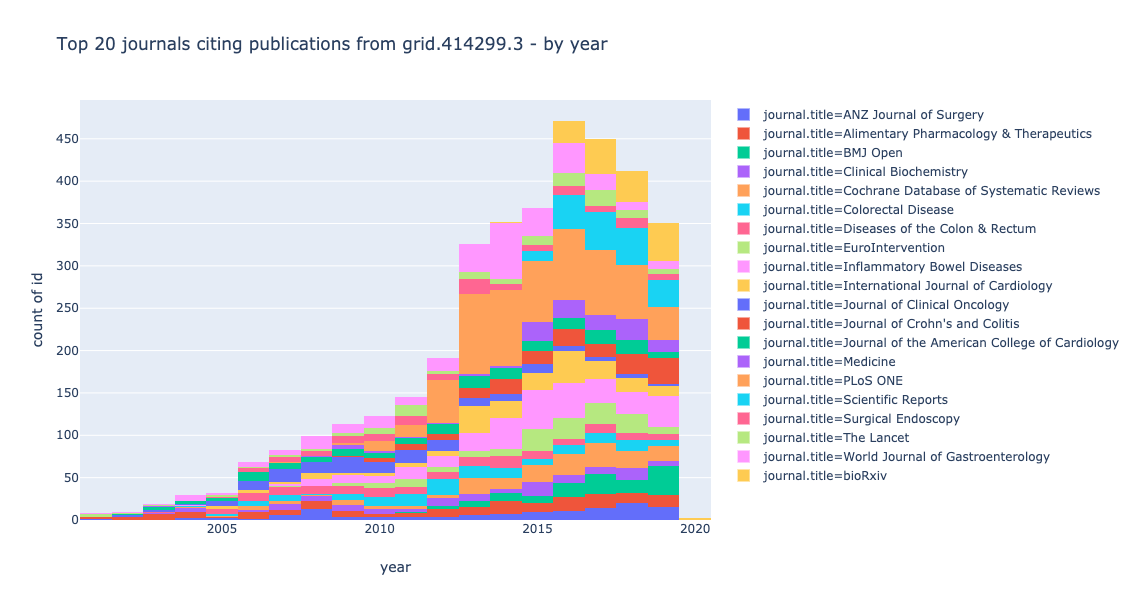

In [26]:
#
#
THRESHOLD = 20  #@param {type: "slider", min: 10, max: 100}
# suppress empty values
pubs_citing.fillna("-no value-", inplace=True)
# make publications list smaller by only showing top journals
pubs_citing_topjournals = pubs_citing[pubs_citing['journal.title'].isin(list(journals[:THRESHOLD]['journal.title']))].sort_values('journal.title')
# build histogram
px.histogram(pubs_citing_topjournals, x="year", y="id", 
                 color="journal.title", 
                title=f"Top {THRESHOLD} journals citing publications from {GRIDID} - by year")